## Step 1 - Load, Preprocess, and Prepare Data

First, I import all data from different csv files and store in different dataframes. The primary keys I am working with are playId, nflId (player), and gameId.

Then I merge all tracking data into one dataframe, since the tracking_data csvs are broken up by week 1 through week 9.
Next I do some preliminary data analysis to see the structure of the files, how many total rows of data I'm be working with, how many receivers I am working with, and what the different event types are.

Last I filter out data I won't need, so that I'm left with only wide receivers and event type pass_arrived.

In [1]:
import pandas as pd
import numpy as np

# gameId, season, week, gameDate, gameTimeEastern, homeTeamAbbr, visitorTeamAbbr, homeFinalScore, visitorFinalScore
games = pd.read_csv('games.csv')

# nflId, height, weight, birthDate, collegeName, position, displayName
players = pd.read_csv('players.csv')

# gameId, playId, ballCarrierId, ballCarrierDisplayName, playDescription, quarter, down, yardsToGo, possessionTeam, defensiveTeam
# yardlineSide, yardlineNumber, gameClock, preSnapHomeScore, preSnapVisitorScore, passResult, passLength, penaltyYards, prePenaltyPlayResult
# playResult, playNullifiedByPenalty, absoluteYardlineNumber, offenseFormation, defendersInTheBox, passProbability, 
# preSnapHomeTeamWinProbability, preSnapVisitorTeamWinProbability, homeTeamWinProbabilityAdded, visitorTeamWinProbilityAdded, 
# expectedPoints, expectedPointsAdded, foulName1, foulName2, foulNFLId1, foulNFLId2
plays = pd.read_csv('plays.csv')

# gameId, playId, nflId, tackle, assist, forcedFumble, pff_missedTackle
tackles = pd.read_csv('tackles.csv')

# gameId, playId, nflId, displayName, frameId, time, jerseyNumber, club, playDirection, x (Player position along the long axis of
# the field, 0 - 120 yards), y (Player position along the short axis of the field, 0 - 53.3 yards), s (Speed in yards/second),
# a (Acceleration in yards/second^2), dis (Distance traveled from prior time point, in yards), o (Player orientation (deg), 0 - 360 degrees),
# dir (Angle of player motion (deg), 0 - 360 degrees), event

# read all tracking data into one large df
tracking_data = pd.concat([pd.read_csv(f'tracking_week_{i}.csv') for i in range(1, 10)])
print(tracking_data)

             gameId  playId    nflId     displayName  frameId  \
0        2022090800      56  35472.0  Rodger Saffold        1   
1        2022090800      56  35472.0  Rodger Saffold        2   
2        2022090800      56  35472.0  Rodger Saffold        3   
3        2022090800      56  35472.0  Rodger Saffold        4   
4        2022090800      56  35472.0  Rodger Saffold        5   
...             ...     ...      ...             ...      ...   
1150018  2022110700    3787      NaN        football       40   
1150019  2022110700    3787      NaN        football       41   
1150020  2022110700    3787      NaN        football       42   
1150021  2022110700    3787      NaN        football       43   
1150022  2022110700    3787      NaN        football       44   

                               time  jerseyNumber      club playDirection  \
0        2022-09-08 20:24:05.200000          76.0       BUF          left   
1        2022-09-08 20:24:05.299999          76.0       BUF      

In [2]:
total_num_rows = len(plays.index) + len(games.index) + len(players.index) + len(tackles.index) + len(tracking_data.index)
print('Total number of rows across all 5 datasets: ', total_num_rows)
print('Percent of Data that is tracking data: ', len(tracking_data.index) / total_num_rows)

Total number of rows across all 5 datasets:  12219129
Percent of Data that is tracking data:  0.9974031700622851


In [3]:
# print all event types 
events = tracking_data.event.unique()
print(events)

# filter all tracking data to only consider data where the event = pass_arrived
pass_arrived_tracking_data = tracking_data[tracking_data['event'] == 'pass_arrived']

[nan 'pass_arrived' 'pass_outcome_caught' 'tackle' 'run' 'first_contact'
 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'pass_forward' 'lateral' 'autoevent_passforward'
 'autoevent_passinterrupted' 'line_set' 'qb_slide' 'shift'
 'run_pass_option' 'qb_sack' 'pass_shovel' 'autoevent_ballsnap'
 'snap_direct' 'fumble_defense_recovered' 'fumble_offense_recovered'
 'penalty_flag' 'safety' 'pass_outcome_touchdown' 'penalty_accepted']


In [4]:
# filter to get all players with position WR (wide receiver)

receivers = plays[['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName', 'passLength']].merge(
    players[['nflId', 'position']], left_on='ballCarrierId', right_on='nflId'
)

receivers = receivers[receivers['position'] == 'WR']
print("total number of receivers: ", len(receivers.index))

total number of receivers:  3338


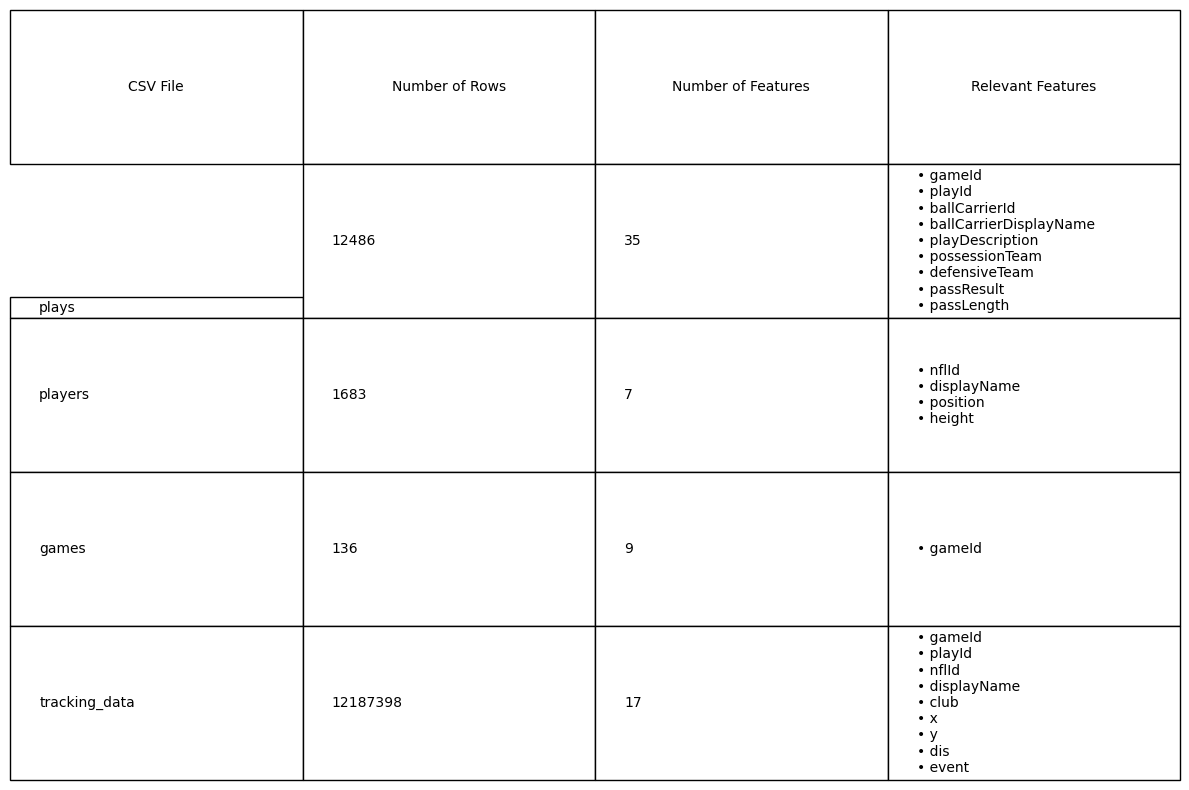

In [5]:
# here I will visualize the information about each of my 4 main dataframes.

import matplotlib.pyplot as plt
import textwrap

# define the table
data = {
    "CSV File": ['plays', 'players', 'games', 'tracking_data'],
    "Number of Rows": [12486, 1683, 136, 12187398],
    "Number of Features": [35, 7, 9, 17],
    "Relevant Features": [
        ['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName', 'playDescription', 'possessionTeam', 'defensiveTeam',
         'passResult', 'passLength'],
        ['nflId', 'displayName', 'position', 'height'],
        ['gameId'],
        ['gameId', 'playId', 'nflId', 'displayName', 'club', 'x', 'y', 'dis', 'event']
    ]
}

# wrap the text within the relevant feature column
def wrap_features(features, width=30):
    bullet_points = [f"• {feature}" for feature in features]
    wrapped = '\n'.join(textwrap.fill(point, width=width) for point in bullet_points)
    return wrapped

data["Relevant Features"] = [wrap_features(features, width=30) for features in data["Relevant Features"]]

# prepare table data
table_data = list(zip(data["CSV File"], data["Number of Rows"], data["Number of Features"], data["Relevant Features"]))

# create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')
ax.axis('tight')

# create table
table = ax.table(
    cellText=table_data,
    colLabels=["CSV File", "Number of Rows", "Number of Features", "Relevant Features"],
    loc='center',
    cellLoc='left'
)

# format
table.auto_set_font_size(False)
table.set_fontsize(10)

# manually set row heights to fit text
for i, row in enumerate(table.get_celld().values()):
    if i == 0:  # Header row, keep it small
        continue
    row.set_height(0.2)  # Increase row height for non-header rows

plt.tight_layout()
plt.show()


## Step 2 - Calculate the "openness" of each receiver at the time the pass arrives.

Next I write a function that goes through all tracking data with pass arrived events. Using the position of all players on the field on the x and y axis, I calculate the Euclidean distance between the receiver and all defenders on the pitch. I then get the minimum distance (closest defender), and this will be the receivers "openness" on that given play in yards.

Ex: openness: 0.25 means that the closest defender at the time the pass arrived was 0.25 yards away.

In [6]:
def calculate_openness(row, tracking_data):
    gameId, playId, nflId, x, y = row['gameId'], row['playId'], row['nflId'], row['x'], row['y']
    
    # filter the tracking data for the same play
    play_data = tracking_data[(tracking_data['gameId'] == gameId) & 
                              (tracking_data['playId'] == playId) & 
                              (tracking_data['nflId'] != nflId) & 
                              (tracking_data['club'] != row['club'])]  # Exclude teammates, only want defenders
    
    # calculate distances to all defenders
    play_data['distance'] = np.sqrt((play_data['x'] - x) ** 2 + (play_data['y'] - y) ** 2)
    
    # return the minimum (distance to closest defender)
    return play_data['distance'].min()

receivers_pass_events = receivers.merge(pass_arrived_tracking_data, on=['gameId', 'playId', 'nflId'])
receivers_pass_events['openness'] = receivers_pass_events.apply(
    calculate_openness, axis=1, tracking_data=pass_arrived_tracking_data
)


In [7]:
wr_openness_information = receivers_pass_events[['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName', 'dis', 'event', 'openness', 'passLength']]

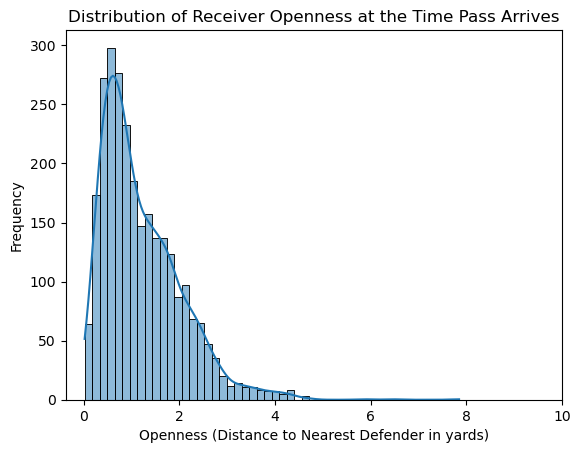

In [8]:
import seaborn as sns

# plot distribution of openness of receivers
sns.histplot(wr_openness_information['openness'], kde=True)
plt.xlim(right=10)
plt.title('Distribution of Receiver Openness at the Time Pass Arrives')
plt.xlabel('Openness (Distance to Nearest Defender in yards)')
plt.ylabel('Frequency')
plt.show()

# Step 3: Calculate average openness and total catches
Calculate average openness, average distance the ball has traveled on catch arrival, and total catches using the given tracking data - plot

In [9]:
# group by 'ballCarrierId' and 'ballCarrierDisplayName', calculate the average openness and total catches for each receiver
average_openness = wr_openness_information.groupby(['ballCarrierId', 'ballCarrierDisplayName'])['openness'].mean().reset_index()
average_openness.rename(columns={'openness': 'average_openness'}, inplace=True)

total_catches = wr_openness_information[wr_openness_information['event'] == 'pass_arrived'].groupby(['ballCarrierId', 'ballCarrierDisplayName']).size().reset_index(name='total_catches')

wr_openness_information.loc[:, 'passLength'] = wr_openness_information['passLength'].abs()

# calculate the average distance the ball traveled at the time the pass arrvied
average_pass_length = wr_openness_information.groupby(['ballCarrierId', 'ballCarrierDisplayName'])['passLength'].mean().reset_index()
average_pass_length.rename(columns={'passLength': 'average_pass_length'}, inplace=True)

# merge the average openness and pass length DataFrames with the total catches DataFrame
updated_openness = pd.merge(average_openness, total_catches, on=['ballCarrierId', 'ballCarrierDisplayName'], how='left')
updated_openness = pd.merge(updated_openness, average_pass_length, on=['ballCarrierId', 'ballCarrierDisplayName'], how='left')

# fill null values with 0 in case a player has no catches
updated_openness['total_catches'] = updated_openness['total_catches'].fillna(0).astype(int)

# sort merged DataFrame by 'average_openness' in ascending order
sorted_openness = updated_openness.sort_values(by='average_openness', ascending=True)

print(sorted_openness.head())


     ballCarrierId ballCarrierDisplayName  average_openness  total_catches  \
76           46542         Keith Kirkwood          0.152971              1   
8            40024           Keenan Allen          0.363695              3   
95           48051            Steven Sims          0.368783              1   
185          54723           Samori Toure          0.429941              2   
139          53244          Michael Bandy          0.525398              6   

     average_pass_length  
76              2.000000  
8               2.666667  
95              2.000000  
185            15.000000  
139             6.000000  


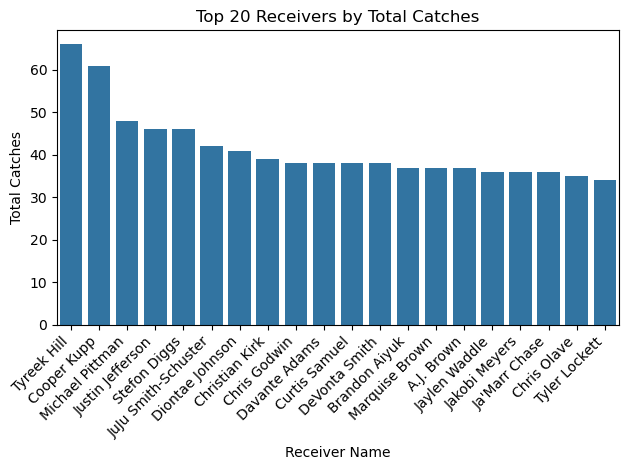

In [10]:
# plot distribution of receivers total catches

# select only the top 20 receivers with the most catches
top_20_receivers = sorted_openness.nlargest(20, 'total_catches')

# plot distribution of total catches for the top 20 receivers using a bar plot
sns.barplot(
    x='ballCarrierDisplayName',
    y='total_catches',
    data=top_20_receivers,
)

plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Receivers by Total Catches')
plt.xlabel('Receiver Name')
plt.ylabel('Total Catches')

# display plot
plt.tight_layout()
plt.show()


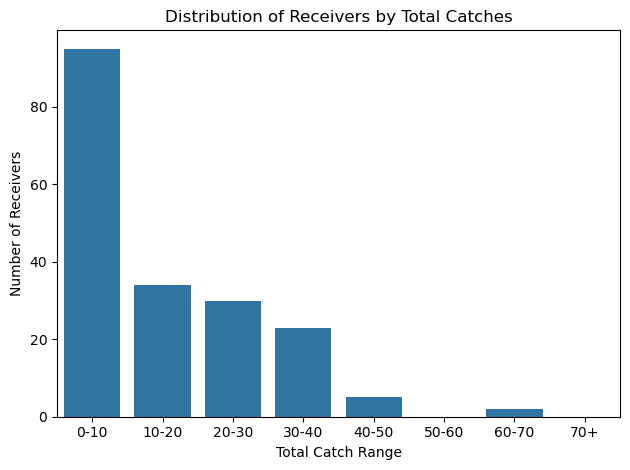

In [11]:
# graph number of receivers within a range of total catches in given bin

# define the bins and labels for the catch ranges
bins = [0, 10, 20, 30, 40, 50, 60, 70, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

# create a new column in the df for the catch range
sorted_openness['catch_range'] = pd.cut(sorted_openness['total_catches'], bins=bins, labels=labels, right=False)

# count the number of receivers in each range
catch_range_counts = sorted_openness['catch_range'].value_counts(sort=False).reset_index()
catch_range_counts.columns = ['Catch Range', 'Number of Receivers']

# plot distribution as a bar chart
sns.barplot(x='Catch Range', y='Number of Receivers', data=catch_range_counts)

plt.title('Distribution of Receivers by Total Catches')
plt.xlabel('Total Catch Range')
plt.ylabel('Number of Receivers')

plt.tight_layout()
plt.show()



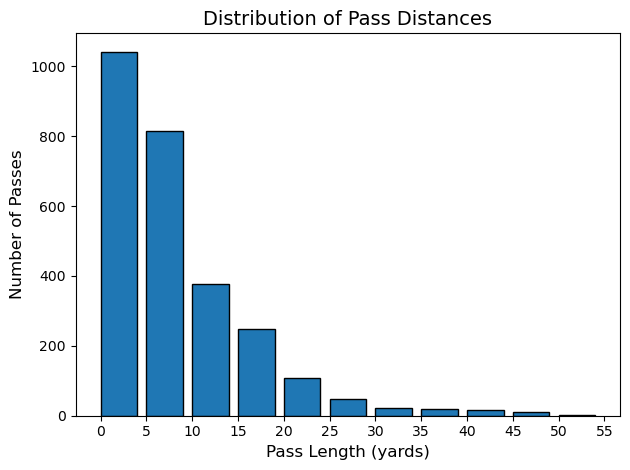

In [12]:
# use the passLength as a column in my DataFrame 'wr_openness_information'
pass_lengths = wr_openness_information['passLength'].abs()

# create a histogram with bins of 5 yards each
bins = range(0, int(pass_lengths.max()) + 5, 5)
counts, edges = np.histogram(pass_lengths, bins=bins)

# plot each bar with a uniform color
plt.bar(edges[:-1], counts, width=4, edgecolor='black', align='edge')

plt.xlabel('Pass Length (yards)', fontsize=12)
plt.ylabel('Number of Passes', fontsize=12)
plt.title('Distribution of Pass Distances', fontsize=14)
plt.xticks(range(0, int(pass_lengths.max()) + 5, 5), fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


# Step 4 - Determine Feature Weights
I then import Madden 2022 receiver ratings so that I can use this as my target output for my random forest.
I use a random forest to determine how to assign weights to my average_pass_length, average_openness and total_catches variables, which I  then use to calculate my own ratings in step 5.

First, I import the downloaded CSV file from (madden_nfl_23_player_ratings.csv). Then, I extract the names and overall ratings of only the receivers. Then I merge these columns into my sorted_opennes dataframe, and drop redundant columns.

Second, I define my input features 'average_openness', 'total_catches', 'average_pass_length' and my target output which is the madden rating. Then I deploy my random forest, and analyze feature importance to get best weights for the input features. This is used in step 5 for my rating system.

In [13]:
# import madden 23 ratings - this will be used as the target output for my RF
madden_ratings = pd.read_csv('madden_nfl_23_player_ratings.csv')
madden_ratings = madden_ratings[(madden_ratings['Position'] == 'WR')][['Full Name', 'Overall Rating']]

# merge 'first name' and 'last name' into a single column called 'receiverName'
madden_ratings['receiverName'] = madden_ratings['Full Name']

# select final columns for output
madden_ratings = madden_ratings[['receiverName', 'Overall Rating']]

# merge with sorted_openness dataset
merged_madden_df = sorted_openness.merge(
    madden_ratings[['receiverName', 'Overall Rating']],
    left_on='ballCarrierDisplayName',
    right_on='receiverName',
    how='left'
)

# drop the 'ReceiverName' column as I already have ballCarrierDisplayName defined in my sorted_openness data.
merged_madden_df.drop(columns=['receiverName'], inplace=True)

# rename for clarity
merged_madden_df.rename(columns={'Overall Rating': 'maddenRating'}, inplace=True)

print(merged_madden_df)


     ballCarrierId ballCarrierDisplayName  average_openness  total_catches  \
0            46542         Keith Kirkwood          0.152971              1   
1            40024           Keenan Allen          0.363695              3   
2            48051            Steven Sims          0.368783              1   
3            54723           Samori Toure          0.429941              2   
4            53244          Michael Bandy          0.525398              6   
..             ...                    ...               ...            ...   
184          42372        Phillip Dorsett          2.258286              5   
185          53658          Mike Strachan          2.444955              3   
186          54536            Velus Jones          2.452454              2   
187          53586   Ihmir Smith-Marsette          2.687006              1   
188          52660        Tyrie Cleveland          3.039234              2   

     average_pass_length catch_range  maddenRating  
0         

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error

features = ['average_openness', 'total_catches', 'average_pass_length']
target = 'maddenRating'

# drop any null values
merged_madden_df.dropna(subset=['maddenRating'], inplace=True)

X = merged_madden_df[features]
y = merged_madden_df[target]

# define training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_estimators=100)

# train model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-Squared: {r2}')


Mean Absolute Error (MAE): 5.129687500000001
Root Mean Squared Error (RMSE): 6.407965014339576
R-Squared: 0.4581227898345276


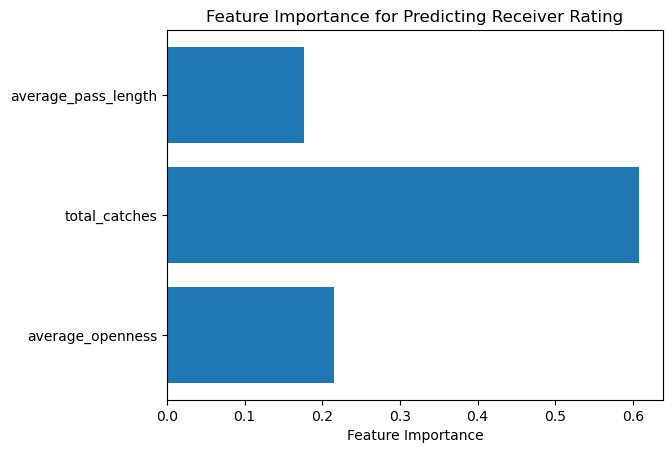

Feature: average_openness, Importance: 0.21502113445515003
Feature: total_catches, Importance: 0.6078842591612886
Feature: average_pass_length, Importance: 0.1770946063835613


In [15]:
# plot of feature importance
feature_importances = model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting Receiver Rating')
plt.show()

# Print feature importances with corresponding feature names
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

# Step 5 - Determine WR Ratings
Using assigned feature weights from my random forest, determine my WR rankings.

In [16]:
from sklearn.preprocessing import MinMaxScaler

# get feature importance and set weights for each feature by creating a dictionary to map each feature to its corresponding weight
features = ['average_openness', 'total_catches', 'average_pass_length']
feature_importances = model.feature_importances_
feature_weights = {feature: weight for feature, weight in zip(features, feature_importances)}

for feature, weight in feature_weights.items():
    globals()[f"{feature}_weight"] = weight

# print dictionary of feature to weight mapping
print(feature_weights)  

# normalize all feature values
scaler = MinMaxScaler()
updated_openness[['normalized_openness', 'normalized_catches', 'normalized_pass_length']] = scaler.fit_transform(
    updated_openness[['average_openness', 'total_catches', 'average_pass_length']]
)

# invert the normalized_openness since lower openness is better
updated_openness['inverted_openness'] = 1 - updated_openness['normalized_openness']

# calculate the weighted score using weights defined above
updated_openness['weighted_score'] = (
    total_catches_weight * updated_openness['normalized_catches']
    + average_openness_weight * updated_openness['inverted_openness']
    + average_pass_length_weight * updated_openness['normalized_pass_length']
)

# scale the weighted score to make the highest value 1.00 and others relative to it
max_score = updated_openness['weighted_score'].max()
updated_openness['weighted_score'] = updated_openness['weighted_score'] / max_score

updated_openness.dropna(subset=['weighted_score'], inplace=True)


# sort by the scaled weighted score
filtered_sorted_openness = updated_openness.sort_values(by='weighted_score', ascending=False)
print(filtered_sorted_openness)

{'average_openness': 0.21502113445515003, 'total_catches': 0.6078842591612886, 'average_pass_length': 0.1770946063835613}
     ballCarrierId ballCarrierDisplayName  average_openness  total_catches  \
35           43454            Tyreek Hill          1.083429             66   
45           44881            Cooper Kupp          1.220235             61   
113          52430       Justin Jefferson          0.993929             46   
26           42489           Stefon Diggs          1.184458             46   
116          52442        Michael Pittman          1.454158             48   
..             ...                    ...               ...            ...   
106          48601          Tyron Johnson          1.725398              1   
165          54428      Maurice Alexander          1.935820              1   
157          53586   Ihmir Smith-Marsette          2.687006              1   
177          54536            Velus Jones          2.452454              2   
133          52660  

# Step 5 - Rank Players

In [17]:
# rank players based on 'weighted_score' in descending order (higher score = better rank)
filtered_sorted_openness['rank'] = filtered_sorted_openness['weighted_score'].rank(ascending=False).astype(int)

# sort the df by rank and display the first 20 players
sorted_composite_wr_ranking = filtered_sorted_openness.sort_values(by='rank')

# style `sorted_composite_wr_ranking`
styled_df = sorted_composite_wr_ranking[['rank', 'ballCarrierDisplayName', 'weighted_score', 'total_catches']].head(20).style

# highlight maximum weighted_score
styled_df = styled_df.highlight_max(subset=['weighted_score'], color='lightgreen')

# format the weighted_score and total_catches columns
styled_df = styled_df.format({
    'weighted_score': '{:.2f}',  # Format to 2 decimal places
    'total_catches': '{:,.0f}'    # Format to whole numbers
})

styled_df

,rank,ballCarrierDisplayName,weighted_score,total_catches
35,1,Tyreek Hill,1.00,66
45,2,Cooper Kupp,0.91,61
113,3,Justin Jefferson,0.77,46
26,4,Stefon Diggs,0.76,46
116,5,Michael Pittman,0.73,48
89,6,Diontae Johnson,0.70,41
62,7,Christian Kirk,0.69,39
141,8,Jaylen Waddle,0.68,36
14,9,Davante Adams,0.68,38
44,10,JuJu Smith-Schuster,0.67,42


# Step 6 - Deploy models
As my Big Data Bowl Dataset is missing values such as incomplete passes, and interceptions, I first scrape the website https://www.nflfastr.com/ - to gather all missing data. Then I filter so that I only analyze pass events from week 1-9, to match my data.

Then I format this scraped data and my composite ratings data (above) so that receiver names are matching, and I merge these dataframes, so that I am left with one data frame containing all relevant information: incomplete_pass, complete_pass, interception, receiver_player_name, play_id, game_id, weighted_score, total_catches, desc, and air_yards.

In [18]:
YEAR = 2022

scraped_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

filtered_scraped_data = scraped_data[
    (scraped_data['week'] <= 9) & 
    (scraped_data['play_type'] == 'pass')
][[
    'old_game_id', 'play_id','complete_pass', 'incomplete_pass','passer_player_name',
    'receiver_player_name', 'interception', 'desc', 'air_yards'
]]

print(filtered_scraped_data)

       old_game_id  play_id  complete_pass  incomplete_pass  \
3       2022091107       89            0.0              1.0   
5       2022091107      136            0.0              1.0   
7       2022091107      202            1.0              0.0   
8       2022091107      230            1.0              0.0   
11      2022091107      301            1.0              0.0   
...            ...      ...            ...              ...   
23663   2022110610     4503            0.0              1.0   
23664   2022110610     4525            0.0              1.0   
23668   2022110610     4602            0.0              0.0   
23669   2022110610     4621            0.0              0.0   
23671   2022110610     4640            0.0              1.0   

      passer_player_name receiver_player_name  interception  \
3               J.Flacco            Mi.Carter           0.0   
5               J.Flacco                  NaN           0.0   
7              L.Jackson            R.Bateman         

In [19]:
import re

# function to standardize names to the format "T.Hill"
def format_name(full_name):
    parts = full_name.split()
    if len(parts) > 1:
        first_initial = parts[0][0]
        last_name = parts[-1]
        return f"{first_initial}.{last_name}"  # Format as "M.Carter"
    return full_name  # Return as is if there's no last name

filtered_sorted_openness.dropna(subset=['ballCarrierDisplayName'], inplace=True)

# standardize 'ballCarrierDisplayName' in sorted_composite_wr_ranking
filtered_sorted_openness['ballCarrierDisplayName'] = filtered_sorted_openness['ballCarrierDisplayName'].apply(format_name)

# create a mapping of standardized receiver names to weighted scores
receiver_mapping_weighted_score = dict(zip(
    filtered_sorted_openness['ballCarrierDisplayName'], 
    filtered_sorted_openness['weighted_score'],
))

receiver_mapping_total_catches = dict(zip(
    filtered_sorted_openness['ballCarrierDisplayName'], 
    filtered_sorted_openness['total_catches']
))

filtered_scraped_data.dropna(subset=['receiver_player_name'], inplace=True)

# standardize 'receiver_player_name' in filtered_scraped_data
filtered_scraped_data['receiver_player_name'] = filtered_scraped_data['receiver_player_name'].apply(format_name)

# functions to get the weighted score and total catches of receivers based on standardized names
def get_weighted_score(desc):
    for name in receiver_mapping_weighted_score.keys():
        if name in desc:
            return receiver_mapping_weighted_score[name]
    return np.nan

def get_total_catches(desc):
    for name in receiver_mapping_total_catches.keys():
        if name in desc: 
            return receiver_mapping_total_catches[name]
    return np.nan

# apply the function to add the weighted_score column
filtered_scraped_data['weighted_score'] = filtered_scraped_data['desc'].apply(get_weighted_score)
filtered_scraped_data['total_catches'] = filtered_scraped_data['desc'].apply(get_total_catches)
filtered_scraped_data['air_yards'] = filtered_scraped_data['air_yards'].abs()

# merge tracking_data with players DataFrame to get position information
tracking_data_wr = tracking_data.merge(players[['nflId', 'position']], on='nflId', how='left')

# filtering to only include rows where event is 'pass_arrived' and position is 'WR'
tracking_data_wr = tracking_data_wr[
    (tracking_data_wr['event'] == 'pass_arrived') &
    (tracking_data_wr['position'] == 'WR')
]

# merge complete pass and incomplete pass columns (from scraped data) into tracking_data based on playId
merged_data = pd.merge(
    tracking_data_wr,
    filtered_scraped_data[['play_id', 'weighted_score', 'total_catches', 'complete_pass', 'incomplete_pass', 'air_yards']],
    left_on='playId',
    right_on='play_id',
    how='left'
)

# sort by frameId and drop duplicates to keep the first frame for each playId
filtered_scraped_data = (
    merged_data.sort_values(by=['gameId', 'playId', 'nflId', 'frameId'])
    .drop_duplicates(subset=['gameId', 'playId', 'nflId'])
)

# display the updated DataFrame
print(filtered_scraped_data)

           gameId  playId    nflId       displayName  frameId  \
0      2022090800      56  42489.0      Stefon Diggs        2   
21     2022090800      56  44985.0   Isaiah McKenzie        2   
42     2022090800      56  52536.0        Gabe Davis        2   
63     2022090800     122  42489.0      Stefon Diggs        3   
68     2022090800     122  44985.0   Isaiah McKenzie        3   
...           ...     ...      ...               ...      ...   
41787  2022110700    3429  53098.0  Marquez Callaway        2   
41790  2022110700    3429  54476.0       Chris Olave        2   
41793  2022110700    3480  46160.0    Tre'Quan Smith        1   
41796  2022110700    3480  53098.0  Marquez Callaway        1   
41799  2022110700    3480  54476.0       Chris Olave        1   

                             time  jerseyNumber club playDirection      x  \
0      2022-09-08 20:24:05.299999          14.0  BUF          left  80.48   
21     2022-09-08 20:24:05.299999           6.0  BUF          lef

In [20]:
# prepare and split data for model deployment 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# data preparation
df = filtered_scraped_data.copy()
df = df.dropna(subset=['air_yards', 'total_catches', 'weighted_score'])

# define features and target
features = df[['weighted_score', 'air_yards', 'total_catches']]
target = df['complete_pass']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# MODEL 1 - Logistic Regression
from sklearn.linear_model import LogisticRegression

# train and predict on LR model
model_lr = LogisticRegression(C=10, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")

report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
print(report_lr)


Accuracy: 0.8069
Precision: 0.8121
Recall: 0.9878
{'0.0': {'precision': 0.6, 'recall': 0.07430340557275542, 'f1-score': 0.1322314049586777, 'support': 323.0}, '1.0': {'precision': 0.8120678818353237, 'recall': 0.9877675840978594, 'f1-score': 0.8913418420144877, 'support': 1308.0}, 'accuracy': 0.8068669527896996, 'macro avg': {'precision': 0.7060339409176619, 'recall': 0.5310354948353074, 'f1-score': 0.5117866234865827, 'support': 1631.0}, 'weighted avg': {'precision': 0.770070379791909, 'recall': 0.8068669527896996, 'f1-score': 0.7410091190414486, 'support': 1631.0}}


In [22]:
# MODEL 2 - Random Forest
from sklearn.ensemble import RandomForestClassifier

# train and predict on RF model

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

# evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")

report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
print(report_rf)

Accuracy: 0.9178
Precision: 0.9310
Recall: 0.9694
{'0.0': {'precision': 0.8513011152416357, 'recall': 0.7089783281733746, 'f1-score': 0.7736486486486487, 'support': 323.0}, '1.0': {'precision': 0.9309838472834068, 'recall': 0.9694189602446484, 'f1-score': 0.949812734082397, 'support': 1308.0}, 'accuracy': 0.917841814837523, 'macro avg': {'precision': 0.8911424812625213, 'recall': 0.8391986442090115, 'f1-score': 0.8617306913655228, 'support': 1631.0}, 'weighted avg': {'precision': 0.9152036373205055, 'recall': 0.917841814837523, 'f1-score': 0.9149255485550513, 'support': 1631.0}}


In [23]:
# MODEL 3 - KNN
from sklearn.neighbors import KNeighborsClassifier

# train and predict on KNN model

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

# evaluate
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")

report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
print(report_knn)

Accuracy: 0.8657
Precision: 0.9007
Recall: 0.9358
{'0.0': {'precision': 0.6911764705882353, 'recall': 0.5820433436532507, 'f1-score': 0.6319327731092437, 'support': 323.0}, '1.0': {'precision': 0.9006622516556292, 'recall': 0.9357798165137615, 'f1-score': 0.9178852643419573, 'support': 1308.0}, 'accuracy': 0.8657265481299816, 'macro avg': {'precision': 0.7959193611219322, 'recall': 0.7589115800835061, 'f1-score': 0.7749090187256005, 'support': 1631.0}, 'weighted avg': {'precision': 0.8591761037189228, 'recall': 0.8657265481299816, 'f1-score': 0.861255801026098, 'support': 1631.0}}


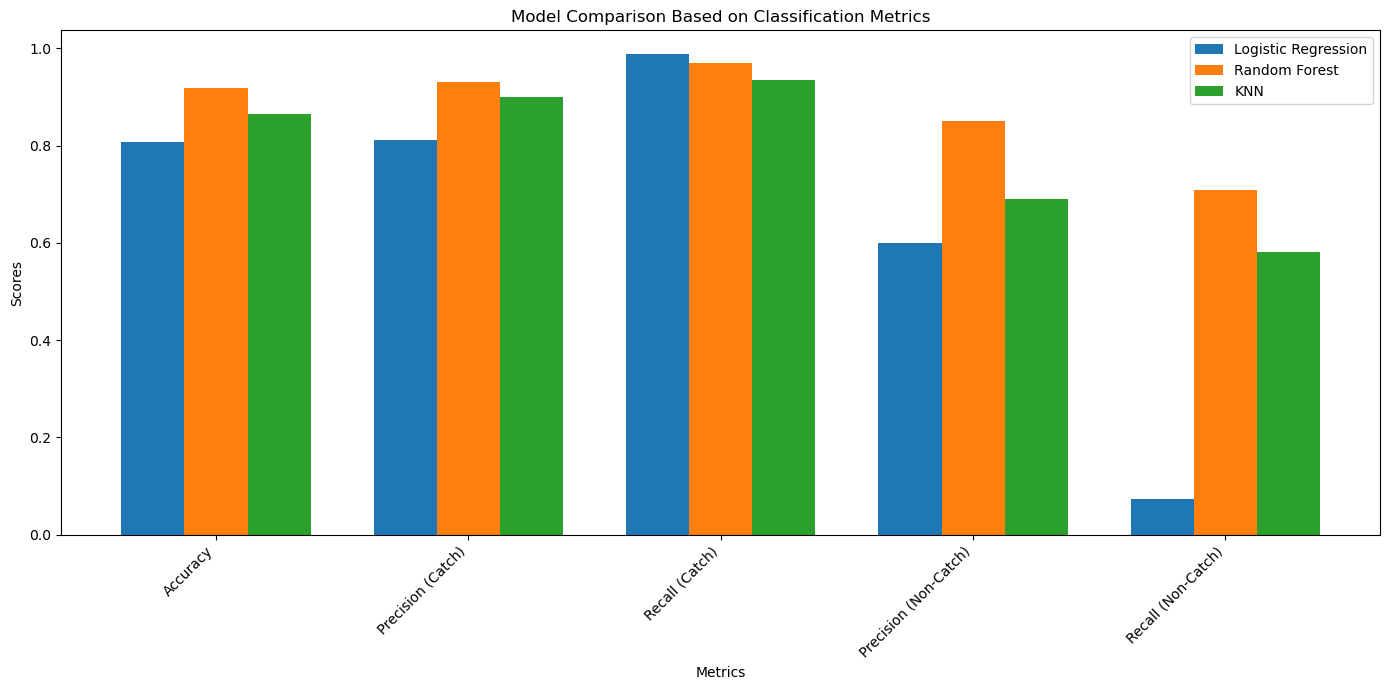

In [24]:
# extract metrics
def extract_metrics(report):
        scores = {
            'Accuracy': report.get('accuracy', 0),
            'Precision (Catch)': report['1.0']['precision'],
            'Recall (Catch)': report['1.0']['recall'],
            'Precision (Non-Catch)': report['0.0']['precision'],
            'Recall (Non-Catch)': report['0.0']['recall'],
        }
        return scores

# extract metrics from the repot of each model
lr_scores = extract_metrics(report_lr)
rf_scores = extract_metrics(report_rf)
knn_scores = extract_metrics(report_knn)

# prepare data for plotting
labels = list(lr_scores.keys())
lr_values = list(lr_scores.values())
rf_values = list(rf_scores.values())
knn_values = list(knn_scores.values())

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))
bar1 = ax.bar(x - width, lr_values, width, label='Logistic Regression')
bar2 = ax.bar(x, rf_values, width, label='Random Forest')
bar3 = ax.bar(x + width, knn_values, width, label='KNN')

# add chart labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison Based on Classification Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# display plot
plt.tight_layout()
plt.show()


# Step 7: Compare and Evaluate Models 

In [25]:
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "K-Nearest Neighbors"],
    "Accuracy": [accuracy_lr, accuracy_rf, accuracy_knn],
    "Precision": [precision_lr, precision_rf, precision_knn],
    "Recall": [recall_lr, recall_rf, recall_knn],
})

styled_df = results_df.style.highlight_max(subset=["Accuracy", "Precision", "Recall"], 
                                           color="lightgreen")

# display styled DataFrame
styled_df

,Model,Accuracy,Precision,Recall
0,Logistic Regression,0.806867,0.812068,0.987768
1,Random Forest,0.917842,0.930984,0.969419
2,K-Nearest Neighbors,0.865727,0.900662,0.935780
